In [ ]:
# experimento com as 7 primeiras semanas da Tommy e Palmer, empregando a validação estratificada

In [29]:
import cv2
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import timeit
import math
from shutil import copyfile

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

%load_ext autoreload
plt.rcParams['figure.figsize'] = [30, 25]

path = os.getcwd()+'//..//imagens//'
sys.path.append(os.getcwd()+'//..//scripts//')
from MNG import MNG
from MNGFolds import MNGFolds
from MNGSegmentation import MNGSegmentation
from MNGPreProcessing import MNGPreProcessing
from MNGContour import MNGContour
from MNGFeaturesMeans import MNGFeaturesMeans
from MNGModel import MNGModel
from MNGFeaturesSize import MNGFeaturesSize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
path = os.getcwd() + '//..//imagens//'
path = '//home//danielesreis//Desktop//'
imgs = os.listdir(path)
img_names = [img.split('.')[0] for img in imgs]

mng = MNG(path, img_names, 'sst', 20)
mng.segmentation = MNGSegmentation()
mng.preprocessing = MNGPreProcessing(mng.segmentation)
mng.contour = MNGContour()

features_mlr = mng.features.feature_names[:9]
mng.features.current_features = features_mlr
mng.features.current_features_name = 'means'
mng.features.new_df()

In [16]:
def pre_process(img, ori, dest):
    bgr = cv2.imread(ori+img)
    med = mng.preprocessing.median_filter(bgr, 5)
    filt, __ = mng.segmentation.otsu_thresholding(med)
#     filt = mng.preprocessing.opening_operation(filt, np.ones((35,35), np.uint8))
#     filt = mng.preprocessing.remove_shadow(filt, 20)
#     filt = mng.preprocessing.closing_operation(filt, med, np.ones((1200,1200), np.uint8))
    filt[filt==0] = 255
    filt = mng.contour.cut_image(filt)
    cv2.imwrite(dest+img, filt)

In [19]:
im = cv2.imread('img.jpg')

In [22]:
med = mng.preprocessing.median_filter(im,5)

In [51]:
filt, __ = mng.segmentation.otsu_thresholding(med)

In [52]:
filt = mng.preprocessing.opening_operation(filt, np.ones((35, 35), np.uint8))

In [53]:
filt = mng.preprocessing.remove_shadow(filt, 90)

In [55]:
filt = mng.preprocessing.closing_operation(filt, med, np.ones((1000, 1000), np.uint8))

In [57]:
filt[filt==0] = 255

In [59]:
filt = mng.contour.cut_image(filt)

In [61]:
cv2.imwrite('../img.jpg', filt)

True

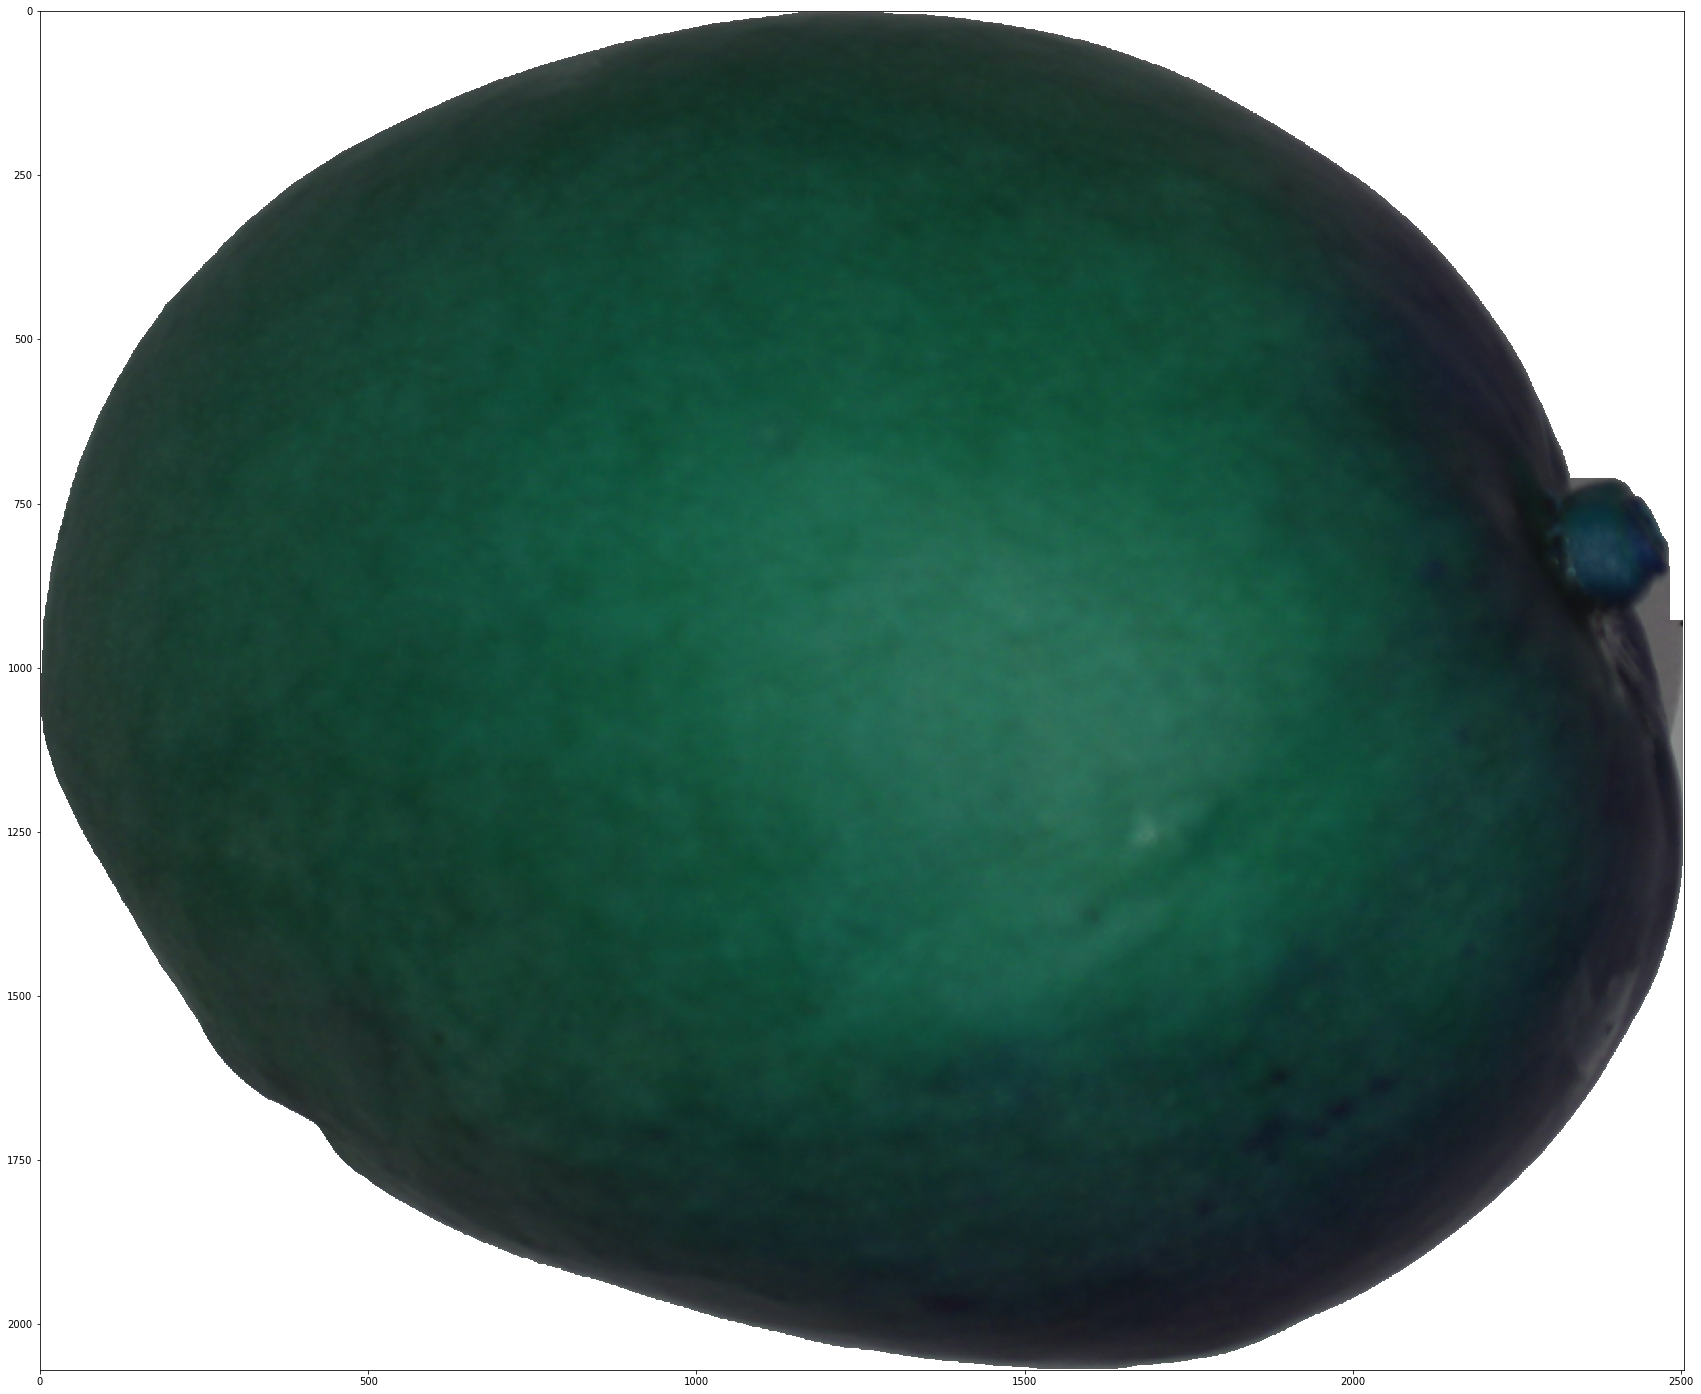

In [60]:
plt.imshow(filt)

In [5]:
path2 = path + '\\..\\pendentes\\' 
path3 = path + '\\..\\pendentes2\\'

imgs = os.listdir(path)

In [26]:
erradas = pd.read_csv(path + '\\..\\sombras.csv', sep=';', dtype='object').values
erradas = [err[0] for err in erradas]
dict_erradas = dict((el,0) for el in erradas)

for img in imgs:
    if img[:4] in dict_erradas:
        copyfile(path+img, path2+img)

In [4]:
erradas = os.listdir(path+'//..//newprocessed//')
dict_erradas = dict((el,1) for el in erradas)        

In [ ]:
imgs = os.listdir(path)

for img in imgs:
    if img in dict_erradas:
        pre_process(img, path, path+'//..//newprocessed//')

In [ ]:
imgs = os.listdir(path2)
nums = np.arange(1,1681)

for img,num in zip(imgs,nums):
    print(num)
    bgr = cv2.imread(path2+img)
    mng.features.extract_features(bgr, img)
    
file_path = mng.features.save_data()

In [ ]:
file_path = 'C:\\Users\\DaniR\\Desktop\\mng\\features\\means_all_half.csv'

palmer_sst 		= 'C:\\Users\\DaniR\\Desktop\\mng\\palmer_sst.csv'
tommy_sst 		= 'C:\\Users\\DaniR\\Desktop\\mng\\tommy_sst.csv'
mng.features.add_target(file_path, palmer_sst, tommy_sst)

In [6]:
mng.folds = MNGFolds(path, file_path, 7)
mng.folds.separate_folds()

In [10]:
model_type = 'all'
mng.model = MNGModel(path, mng.folds, model_type, 'sst')
mng.model.build_mlr_model(model_type, features_mlr)
mng.model.build_rf_model(model_type)

[0.09393643 0.04809092 0.28558104 0.16237886 0.14400014 0.04285461
 0.0363008  0.12820476 0.05865244]
[0.08227043 0.04770149 0.28880849 0.17416228 0.1467393  0.04807344
 0.03566097 0.11953713 0.05704647]
[0.08507982 0.05113184 0.29271413 0.15348792 0.1472437  0.04147874
 0.03470888 0.13989307 0.05426189]
[0.08242695 0.05154439 0.25953241 0.16859541 0.14968057 0.04454441
 0.04003746 0.14270358 0.06093481]
[0.08717648 0.04925476 0.27222555 0.15654254 0.13855823 0.04590827
 0.03960447 0.14686254 0.06386716]
[0.09052128 0.05526893 0.22858881 0.16430464 0.17183936 0.04760122
 0.03556472 0.13521969 0.07109135]
[0.10067472 0.05219003 0.26271891 0.09636471 0.16761535 0.05764585
 0.03815849 0.15376062 0.07087133]


In [450]:
df = pd.read_csv('C:\\Users\\juju-\\Desktop\\projetos\\mng\\features\\means_all.csv', sep=';', index_col=0)

new_data = df.copy()
columns = df.columns
index = df.index.values

info = list()
info = [ind.split('_') for ind in index]

var = [inf[0][4:] for inf in info]
sem = [int(inf[1][-1]) for inf in info]
num = [int(inf[2].split('lado')[0][3:]) for inf in info]
lado= [int(inf[2][-1]) for inf in info]

var = pd.Series(var, index)
sem = pd.Series(sem, index)
num = pd.Series(num, index)
lado = pd.Series(lado, index)

new_data['var'] = var
new_data['sem'] = sem
new_data['num'] = num
new_data['lado'] = lado

# new_data = new_data.loc[new_data['lado']==1]
new_data = new_data.groupby(['var', 'sem', 'num']).sum()
new_data = new_data.reset_index().drop(columns=['var', 'sem', 'num', 'lado'])
# new_data = new_data.drop(columns=['var', 'sem', 'num', 'lado'])

new_index = [ind.split('lado')[0] for ind in index]
new_index = new_index[::2]

new_data['ind'] = new_index
new_data.set_index('ind', inplace=True)

file_path = path+'..\\features\\' + 'means' + '_all_half_soma.csv'
new_data.to_csv(file_path, sep=';')

mng.features.add_target(file_path, palmer_sst, tommy_sst)

In [4]:
file_path = 'C:\\Users\\DaniR\\Desktop\\mng\\features\\means_all_half.csv'
mng.folds = MNGFolds(path, file_path, 7)
mng.folds.separate_folds()

In [8]:
model_type = 'all'
mng.model = MNGModel(path, mng.folds, model_type, 'sst')
mng.model.build_mlr_model(model_type, features_mlr)
mng.model.build_rf_model(model_type)